[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/mpariente/asteroid/blob/master/examples/PITLossWrapper.ipynb)

## Permutation invariant training
Permutation invariant training (PIT) was succesfully introduced to train DNN-based speaker-independent speech separation systems [1, 2, 3, 4]. Since then, it has been applied to environmental source separation [5] and classification [6], and end-to-end diarization [7, 8].
There has also been recent work to extend or improve on PIT-based training [9, 10, 11].

Asteroid provides `PITLossWrapper`, a flexible class which enables seamless transformation of simple loss functions into permutation invariant losses, for any loss function and any number of sources!

It supports three types of loss functions :
- 1) The loss function compute the average loss for a given permutation (over all source-estimates). `PITLossWrapper` loops over the permutations and returns the minimum loss, the one to be backproped. (`mode = w_src`)
- 2) Second way, compute pair wise losses and take the mean over each permutation. 
  - a) The pairwise losses can be computed using one function. In this case `PITLossWrapper` finds the best permutation and returns the minimum loss. (`mode = pairwise`)
  - b) The provided function computes the loss for one given target-estimate pair. `PITLossWrapper` computes the pairwise losses by calling this function on each pair. It then finds the best permutation and returns the minimum loss as done in 2b. (`mode = wo_src`)
 
In addition, we provide common loss functions in these three forms.  
Let's try to understand these three ways of computing PIT losses.

In [1]:
# First install asteroid and depencies
#!pip install git+https://github.com/mpariente/asteroid.git@master

In [2]:
import torch
from itertools import permutations
import numpy as np
import matplotlib.pyplot as plt
from asteroid.losses import PITLossWrapper
from asteroid.losses import pairwise_mse, nosrc_mse, nonpit_mse

In [3]:
# To be able to visualize some results, we will take a batch size of 1.
batch_size, n_sources, feat_dim = 1, 4, 50
# First, take random sources
sources = torch.randn(batch_size, n_sources, feat_dim)
# Generate estimates : Randomly permute the sources and add some noise.
random_permutation = torch.randperm(n_sources)
estimate_sources = sources[:, random_permutation] + torch.randn(batch_size, n_sources, feat_dim)

### 1. The Naive Way.
The naive way consists in looping over all permutations on the source axis to find the best one.
It corresponds to the `mode='w_src'`, meaning `with source axis` because the loss function is computed for a set of sources and their estimates.

In [4]:
# The naive way. Find the best loss by looping over the permutations.
perms = list(permutations(range(n_sources)))
all_losses = torch.stack([nonpit_mse(estimate_sources, sources[:, p]) for p in perms])

best_loss_idx = torch.argmin(all_losses)
# We will backprop all_losses[best_loss_idx]
print("Best permutation : {}. 0riginal permutation : {}".format(perms[best_loss_idx], random_permutation))

# This is equivalent to :
loss_func = PITLossWrapper(nonpit_mse, mode='w_src')
best_loss = loss_func(estimate_sources, sources)

Best permutation : (3, 0, 1, 2). 0riginal permutation : tensor([3, 0, 1, 2])


### 2. More efficient way
The first thing to notice is that the loss on one permutation is the sum of between-source losses. We can speed up the naive approach by computing individual pairwise losses and averaging them to compute the loss for each permutation. We can compute the pairwise losses in two ways : 
- The given function compute the loss function for a given pair and we can loop over the pairs. (`mode='wo_src'` for without source axis.)
- The given function computes them directly. (`mode='pairwise'`)

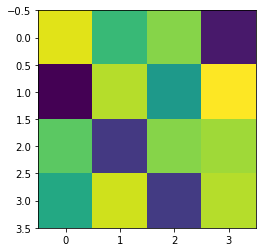

In [5]:
# Without source axis, let's compute the loss for each source-estimate pair.
def mse(est_target, target):
    """ Batch MSE between a source and its estimate"""
    loss = (target - est_target)**2
    return loss.mean(-1)

# Compute pairwise losses
pairwise_losses = torch.zeros(batch_size, n_sources, n_sources)
for i in range(n_sources):
    for j in range(n_sources):
        pairwise_losses[:, i, j] = mse(estimate_sources[:, i], sources[:, j])
# Plot the pairwise losses
ax = plt.imshow(pairwise_losses[0].data.numpy())

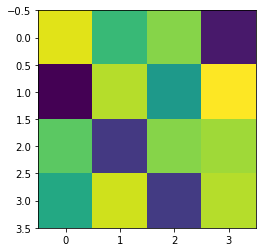

In [6]:
# We can also compute the pairwise losses directly using dimension broadcasting
def pairwise_mse(est_targets, targets):
    """ Batch pairwise MSE. """
    targets = targets.unsqueeze(1)
    est_targets = est_targets.unsqueeze(2)
    pw_loss = (targets - est_targets)**2
    mean_over = list(range(3, pw_loss.ndim))
    return pw_loss.mean(dim=mean_over)
# Compute pairwise losses using broadcasting (+ unit test equality)
direct_pairwise_losses = pairwise_mse(estimate_sources, sources)
torch.testing.assert_allclose(pairwise_losses, direct_pairwise_losses)
# Plot the pairwise losses
ax = plt.imshow(direct_pairwise_losses[0].data.numpy())

Now that we have the loss values for each source-estimate pair, we can compute the average over this matrix for each permutation. 
Below are plotted the one-hot permutation matrices, which will be individually multiplied with the `pairwise_losses`.

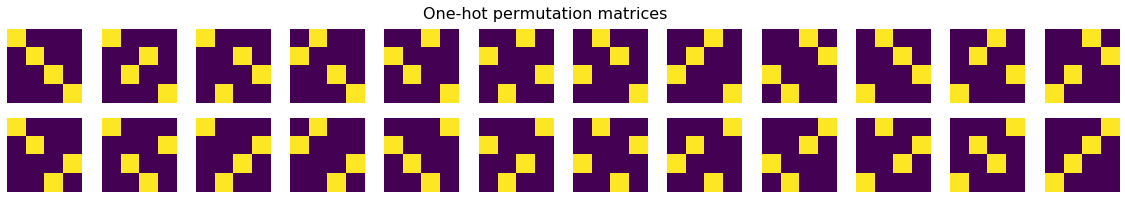

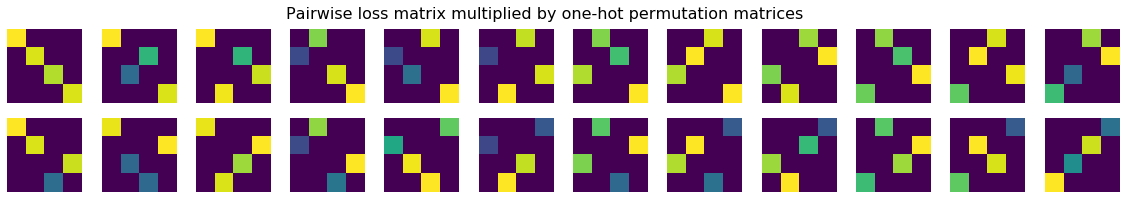

In [7]:
# Let's plot all the permutation matrices
eye = torch.eye(n_sources)
perms_one_hot = torch.stack([eye[:, perm] for perm in perms], dim=0)
fig, axs = plt.subplots(2, len(perms)//2, figsize=(20, 3))
fig.suptitle('One-hot permutation matrices', fontsize=16)
for i in range(len(perms)):
    col, line = divmod(i, 2)
    axs[line, col].imshow((perms_one_hot[i]).data.numpy())
    axs[line, col].set_axis_off()

fig, axs = plt.subplots(2, len(perms)//2, figsize=(20, 3))
fig.suptitle('Pairwise loss matrix multiplied by one-hot permutation matrices', fontsize=16)
for i in range(len(perms)):
    col, line = divmod(i, 2)
    axs[line, col].imshow((perms_one_hot[i] * pairwise_losses[0]).data.numpy())
    axs[line, col].set_axis_off()

The mean of each matrix above is a potential loss, the minimum of which will be backproped.

### Timing the three approaches, for MSE and SI-SDR

In [8]:
print("For MSE")
print("1. Naive approach ")
loss_func = PITLossWrapper(nonpit_mse, mode='w_src')
%timeit best_loss = loss_func(sources, estimate_sources)
print("2. More efficient approaches (b)")
loss_func = PITLossWrapper(nosrc_mse, mode='wo_src')
%timeit best_loss = loss_func(sources, estimate_sources)
print("2. More efficient approaches (b)")
loss_func = PITLossWrapper(pairwise_mse, mode='pairwise')
%timeit best_loss = loss_func(sources, estimate_sources)

For MSE
1. Naive approach 
824 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2. More efficient approaches (b)
653 µs ± 8.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2. More efficient approaches (b)
135 µs ± 980 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
from asteroid.losses import pairwise_neg_sisdr, nosrc_neg_sisdr, nonpit_neg_sisdr
print("For SI-SDR")
print("1. Naive approach ")
loss_func = PITLossWrapper(nonpit_neg_sisdr, mode='w_src')
%timeit best_loss = loss_func(sources, estimate_sources)
print("2. More efficient approaches (b)")
loss_func = PITLossWrapper(nosrc_neg_sisdr, mode='wo_src')
%timeit best_loss = loss_func(sources, estimate_sources)
print("2. More efficient approaches (b)")
loss_func = PITLossWrapper(pairwise_neg_sisdr, mode='pairwise')
%timeit best_loss = loss_func(sources, estimate_sources)

For SI-SDR
1. Naive approach 
3.72 ms ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2. More efficient approaches (b)
2.3 ms ± 2.67 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2. More efficient approaches (b)
272 µs ± 4.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Citations:
Classic PIT-based speech separation :
- [1] Yu, Dong et al. “Permutation Invariant Training of Deep Models for Speaker-Independent Multi-Talker Speech Separation.” 2017 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP).  
- [2] Morten Kolbæk et al. "Multi-talker Speech Separation with Utterance-level Permutation Invariant Training of Deep Recurrent Neural Networks." 2017  
- [3] Luo, Yi, and Nima Mesgarani. “Conv-TasNet: Surpassing Ideal Time–Frequency Magnitude Masking for Speech Separation.” IEEE/ACM Transactions on Audio, Speech, and Language Processing 27.8 (2019)  
- [4] Takahashi, Naoya et al. “Recursive Speech Separation for Unknown Number of Speakers.” Interspeech 2019.  

PIT-based environmental sound separation : 
- [5] Kavalerov, Ilya et al. “Universal Sound Separation.” 2019 IEEE Workshop on Applications of Signal Processing to Audio and Acoustics (WASPAA)   
- [6] Tzinis, Efthymios et al. "Improving Universal Sound Separation Using Sound Classification", 2019. 

PIT-based end-to-end diariazation
- [7] Fujita, Yusuke et al. "End-to-End Neural Speaker Diarization with Permutation-Free Objectives", Interspeech 2019
- [8] Fujita, Yusuke et al. "End-to-End Neural Speaker Diarization with Self-attention", arXiv 2019

Papers on PIT alternatives :
- [9] C. Fan et al. "Utterance-level Permutation Invariant Training with Discriminative Learning for Single Channel Speech Separation," 2018 11th International Symposium on Chinese Spoken Language Processing (ISCSLP).  
- [10] Yang, Gene-Ping et al. "Interrupted and cascaded permutation invariant training for speech separation" 2019.  
- [11] Yousefi, Midia et al. “Probabilistic Permutation Invariant Training for Speech Separation.” Interspeech 2019   